In [1]:
# %pip install pykan

In [50]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
from kan.spline import B_batch, coef2curve

In [45]:
def B_batch(x, grid, k=0, extend=True, device='cpu'):
    '''
    evaludate x on B-spline bases
    
    Args:
    -----
        x : 2D torch.tensor
            inputs, shape (number of splines, number of samples)
        grid : 2D torch.tensor
            grids, shape (number of splines, number of grid points)
        k : int
            the piecewise polynomial order of splines.
        extend : bool
            If True, k points are extended on both ends. If False, no extension (zero boundary condition). Default: True
        device : str
            devicde
    
    Returns:
    --------
        spline values : 3D torch.tensor
            shape (number of splines, number of B-spline bases (coeffcients), number of samples). The numbef of B-spline bases = number of grid points + k - 1.
      
    Example
    -------
    >>> num_spline = 5
    >>> num_sample = 100
    >>> num_grid_interval = 10
    >>> k = 3
    >>> x = torch.normal(0,1,size=(num_spline, num_sample))
    >>> grids = torch.einsum('i,j->ij', torch.ones(num_spline,), torch.linspace(-1,1,steps=num_grid_interval+1))
    >>> B_batch(x, grids, k=k).shape
    torch.Size([5, 13, 100])
    '''

    # x shape: (size, x); grid shape: (size, grid)
    def extend_grid(grid, k_extend=0):
        # pad k to left and right
        # grid shape: (batch, grid)
        h = (grid[:, [-1]] - grid[:, [0]]) / (grid.shape[1] - 1)

        for i in range(k_extend):
            grid = torch.cat([grid[:, [0]] - h, grid], dim=1)
            grid = torch.cat([grid, grid[:, [-1]] + h], dim=1)
        grid = grid.to(device)
        return grid

    if extend == True:
        grid = extend_grid(grid, k_extend=k)
    # print('grid.shape',grid.shape)##torch.Size([1, 5])
    # print('x.shape',x.shape)##torch.Size([1, 1000])
    grid = grid.unsqueeze(dim=2).to(device)
    x = x.unsqueeze(dim=1).to(device)
    # print('grid.shape after',grid.shape)##torch.Size([1, 5, 1])
    # print('x.shape after',x.shape)##torch.Size([1, 1, 1000])

    if k == 0:
        # print('---------------k=0--------------')
        # print(x.shape)##torch.Size([1, 1, 1000])
        # print(grid[:,:-1].shape)##torch.Size([1, 4, 1])
        # print('x \n',x)
        # print('grid[:,:-1] \n',grid[:,:-1])
        # print('grid[:,1:] \n',grid[:,1:])
        value = (x >= grid[:, :-1]) * (x < grid[:, 1:])
        # print(value.shape)
        # print(value)
    else:
        B_km1 = B_batch(x[:, 0], grid=grid[:, :, 0], k=k - 1, extend=False, device=device)
        value = (x - grid[:, :-(k + 1)]) / (grid[:, k:-1] - grid[:, :-(k + 1)]) * B_km1[:, :-1] + (grid[:, k + 1:] - x) / (grid[:, k + 1:] - grid[:, 1:(-k)]) * B_km1[:, 1:]
    return value

### Visualizing B-splines

In [46]:
grid_size = 5
spline_grid = torch.linspace(0, 1, grid_size).reshape(1, -1)
plot_grid = torch.linspace(0, 1, 1000).reshape(1, -1)
# print('spline_grid.shape', spline_grid.shape)
# print('plot_grid.shape', plot_grid.shape)
# aaa = spline_grid[:, :-1]
# print('aaa.shape', aaa.shape) # torch.Size([1, 4])

torch.Size([1, 1, 1000])
torch.Size([1, 4, 1])


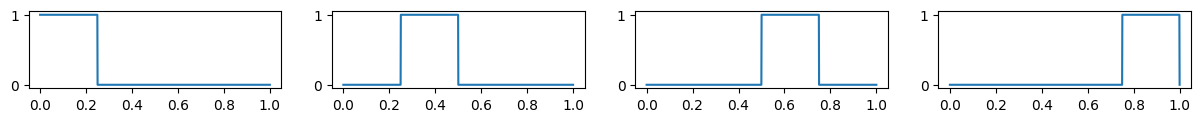

In [47]:
values = B_batch(plot_grid, spline_grid, k=0, extend=False, device='cpu')
# print('values.shape',values.shape)## (1, 4, 1000)
fig, axs = plt.subplots(1, grid_size - 1, sharex=True, figsize=(15, 1))
# print('plot_grid[0].shape',plot_grid[0].shape)## (1000,)
for i in range(grid_size - 1):
  axs[i].plot(plot_grid[0], values[0, i, :])

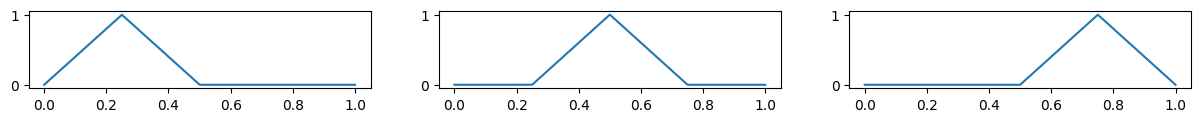

In [6]:
values = B_batch(plot_grid, spline_grid, k=1, extend=False, device='cpu')
fig, axs = plt.subplots(1, grid_size - 2, sharex=True, figsize=(15, 1))
for i in range(grid_size - 2):
  axs[i].plot(plot_grid[0], values[0, i, :])

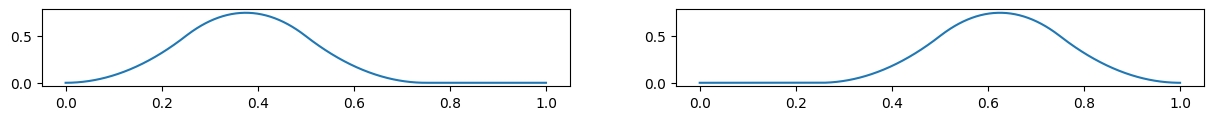

In [ ]:
values = B_batch(plot_grid, spline_grid, k=2, extend=False, device='cpu')
fig, axs = plt.subplots(1, grid_size - 3, sharex=True, figsize=(15, 1))
for i in range(grid_size - 3):
  axs[i].plot(plot_grid[0], values[0, i, :])

In [ ]:
spline_grid

### Visualizing splines

In [51]:
grid_size = 10
n_splines = 5
spline_order = 3

In [52]:
spline_grid = torch.linspace(0, 1, grid_size).reshape(1, -1).repeat(n_splines, 1)
plot_grid = torch.linspace(0, 1, 1000).reshape(1, -1).repeat(n_splines, 1)
spline_coeffs = torch.randn((n_splines, grid_size + spline_order - 1))

In [53]:
y_plot = coef2curve(plot_grid, spline_grid, spline_coeffs, spline_order, device="cpu")

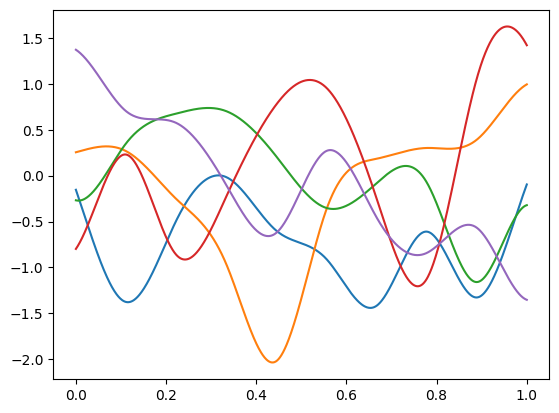

In [54]:
plt.figure()
for i in range(n_splines):
  plt.plot(plot_grid[0, :], y_plot[i, :])